This is a very interesting task and it's very suitable for beginners, through this task you can learn about data analysis, data processing, model building, model training, parameter optimization and so on. When only use the images, with a common network, such as Resnet, Densenet, you can achieve a relatively good accuracy very easily. 

By analyzing the data, the basic information of the patient is also related to the classification of the diseased tissue. Therefore, if we can combine the case information to carry out the classification task, it will be a very meaningful work. Actually during clinical diagnosis, doctors will also combine different modal data to make comprehensive judgments.

Due to the urgency of time, my current method only uses image data, and then I will consider adding the patient's personal information to the classification task to train a more complete model. I will update my kernel immediately once I finished.

Before you really start, I strongly recommend you to read the material of pigmented lesions and dermatoscopic images[https://arxiv.org/abs/1803.10417]. After that, you can learn about the characteristics and distribution of the data from the task description and this kernel[https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing]

In this kernel I have followed following steps for model building and evaluation: 

> Step 1. Data analysis and preprocessing

> Step 2. Model building

> Step 3. Model training

> Step 4. Model evaluation

I used the pytorch framework to complete the entire task. The code contains several common networks, such as Resnet, VGG, Densenet, and Inception. You only need to make minor changes on the code to complete the network switch. Without the hyperparameter adjustment, I used **Densenet-121 to achieve an accuracy of more than 90% on the validation set in 10 epochs.**



 ### First, import all libraries that used in this project

In [1]:
# # Before moving to the next step, pip install a few packages, and then restart for them to become active
# ! pip3 install ipywidgets
# ! pip3 install pandas

In [2]:
! ls /data/mnist_skin/mnist_skin

EDA_abajaj.ipynb		ham10000_images_part_1
HAM10000_images_part_1		ham10000_images_part_2
HAM10000_images_part_2		hmnist_28_28_L.csv
HAM10000_metadata.csv		hmnist_28_28_RGB.csv
ISIC2018_Task3_Test_Images	hmnist_8_8_L.csv
ISIC2018_Task3_Test_Images.zip	hmnist_8_8_RGB.csv
__MACOSX			mnist_skin.zip


In [3]:
#### %matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torch.nn.functional as F


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# print(os.listdir("/data/mnist_skin/mnist_skin/skin-cancer-mnist-ham10000/"))

## Step 1. Data analysis and preprocessing

Get the all image data paths， match the row information in HAM10000_metadata.csv with its corresponding image

In [4]:
data_dir = '/data/mnist_skin/mnist_skin'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# all_image_path
imageid_path_dict

{'ISIC_0031808': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0031808.jpg',
 'ISIC_0032824': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0032824.jpg',
 'ISIC_0034243': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0034243.jpg',
 'ISIC_0030762': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0030762.jpg',
 'ISIC_0033573': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0033573.jpg',
 'ISIC_0032653': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0032653.jpg',
 'ISIC_0029602': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0029602.jpg',
 'ISIC_0031795': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0031795.jpg',
 'ISIC_0030598': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0030598.jpg',
 'ISIC_0032005': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0032005.jpg',
 'ISIC_0031664': '/data/mnist_skin/mnist_skin/ham10000_images_part_2/ISIC_0031664.jpg',
 'ISIC_0033878': '/data/mnist_sk

In [5]:
# Check to see that there are 10,015 images split across the data
!ls /data/mnist_skin/mnist_skin/HAM10000_images_part_1/ | wc -l
!ls /data/mnist_skin/mnist_skin/HAM10000_images_part_2/ | wc -l

5000
5015


This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

In [6]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

Return the mean and std of RGB channels

In [7]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21541/21541 [02:05<00:00, 171.25it/s]


(224, 224, 3, 21541)
normMean = [0.7628294, 0.5463282, 0.570702]
normStd = [0.14125313, 0.15315892, 0.17052336]


Add three columns to the original DataFrame, path (image path), cell_type (the whole name),cell_type_idx (the corresponding index  of cell type, as the image label )

In [8]:
# Metadata - legion_id, image_id, dx (label), dx_type, age, sex, localization
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# Adding in image path
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)

# Adding in full name of dx type
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

# Assigning code to categorical variable - cell_type_idx
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2


In [9]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [10]:
df_dup = df_original.groupby('lesion_id').count()
df_dup = df_dup[df_dup['image_id'] > 1]
df_dup.reset_index(inplace = True)
print(f' {len(df_dup)} lesion_id\'s have two or more associated images')
df_dup.head()

 1956 lesion_id's have two or more associated images


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000000,2,2,2,2,2,2,2,2,2
1,HAM_0000002,3,3,3,3,3,3,3,3,3
2,HAM_0000005,4,4,4,4,4,4,4,4,4
3,HAM_0000006,3,3,3,3,3,3,3,3,3
4,HAM_0000009,3,3,3,3,3,3,3,3,3


Examine two of the "duplicate" images. From documentation, and evident here - we can see these are not exact duplicates. Instead, they are essentially transforms of the same legion.

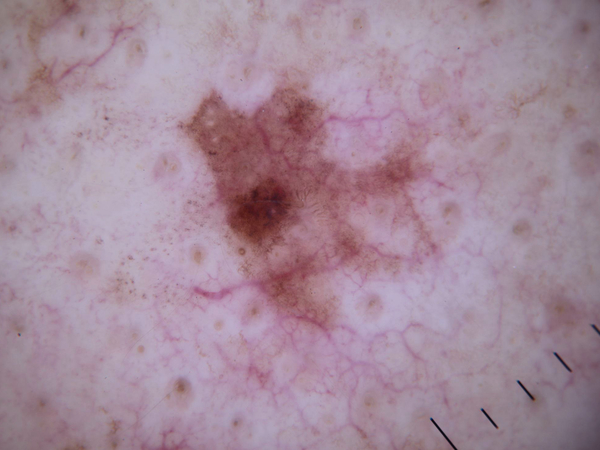

In [11]:
from IPython.display import Image as Image2
Image2(filename = df_original[df_original['lesion_id'] == 'HAM_0000000'].iloc[0][7])

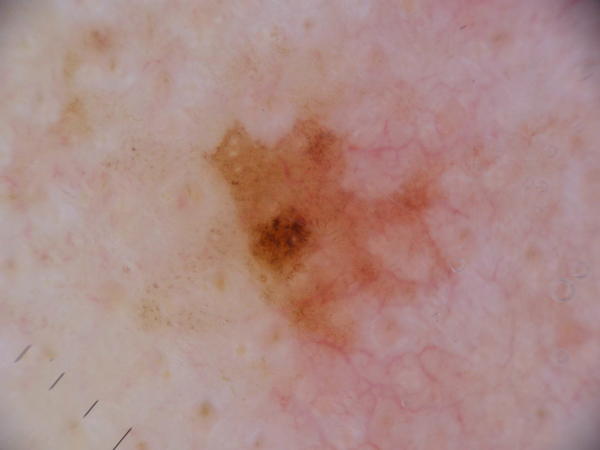

In [12]:
Image2(filename = df_original[df_original['lesion_id'] == 'HAM_0000000'].iloc[1][7])

In [13]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,duplicated


In [14]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [15]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [16]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape
# Notes:
# 1) test_size = .2 ends up being closer to 10% of total images since the df_undup size is only half of overall
# 2) stratify = y retains the class ratios of the original (df_undup) dataset 

(1103, 11)

In [17]:
df_val['cell_type_idx'].value_counts()
df_val

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
4781,HAM_0000199,ISIC_0026127,nv,follow_up,55.0,male,lower extremity,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated
3294,HAM_0006655,ISIC_0025994,nv,follow_up,50.0,female,lower extremity,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated
2089,HAM_0006004,ISIC_0027702,mel,histo,70.0,female,back,/data/mnist_skin/mnist_skin/ham10000_images_pa...,dermatofibroma,6,unduplicated
9816,HAM_0004563,ISIC_0031211,akiec,histo,75.0,male,lower extremity,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Actinic keratoses,0,unduplicated
8611,HAM_0004275,ISIC_0026921,nv,histo,70.0,female,back,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated
...,...,...,...,...,...,...,...,...,...,...,...
5807,HAM_0007192,ISIC_0030558,nv,follow_up,35.0,female,upper extremity,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated
3860,HAM_0004307,ISIC_0031714,nv,follow_up,70.0,male,face,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated
363,HAM_0004501,ISIC_0028856,bkl,histo,65.0,male,back,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Benign keratosis-like lesions,2,unduplicated
3445,HAM_0007527,ISIC_0032426,nv,follow_up,45.0,female,back,/data/mnist_skin/mnist_skin/ham10000_images_pa...,Melanocytic nevi,4,unduplicated


In [18]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [19]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [20]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

**From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.**

In [21]:
# # Copy fewer class to balance the number of 7 classes
# data_aug_rate = [15,10,5,50,0,40,5]
# for i in range(7):
#     if data_aug_rate[i]:
#         df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
# df_train['cell_type'].value_counts()

At the beginning, I divided the data into three parts, training set, validation set and test set. Considering the small amount of data, I did not further divide the validation set data in practice.

In [22]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

## Step 2. Model building

In [23]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

You can change your backbone network, here are 4 different networks, each network also has sevaral versions. Considering the limited training data, we used the ImageNet pre-training model for fine-tuning. This can speed up the convergence of the model and improve the accuracy.

There is one thing you need to pay attention to, the input size of Inception is different from the others (299x299), you need to change the setting of compute_img_mean_std() function 

In [25]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [26]:
# dir(model_ft)

In [27]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [28]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [29]:
df_train = df_train[df_train.columns[[0,8,10]]]

In [30]:
df_val = df_val[df_val.columns[[0,8,10]]]

In [31]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [32]:
# next(iter(train_loader))

In [33]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [34]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss().to(device)
criterion = FocalLoss()

## Step 3. Model training

In [35]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [37]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [38]:
epoch_num = 200
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    print('starting train')
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     print('1')
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     print('2')
    total_loss_val.append(loss_val)
#     print('3')
    total_acc_val.append(acc_val)
#     print('4')
    if acc_val > best_val_acc:
#         print('5')
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

starting train
[epoch 1], [iter 100 / 279], [train loss 0.36634], [train acc 0.68250]
[epoch 1], [iter 200 / 279], [train loss 0.34519], [train acc 0.68016]
------------------------------------------------------------
[epoch 1], [val loss 0.08252], [val acc 0.85256]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.08252], [val acc 0.85256]
*****************************************************
starting train
[epoch 2], [iter 100 / 279], [train loss 0.22989], [train acc 0.71313]
[epoch 2], [iter 200 / 279], [train loss 0.22718], [train acc 0.71578]
------------------------------------------------------------
[epoch 2], [val loss 0.08693], [val acc 0.84631]
------------------------------------------------------------
starting train
[epoch 3], [iter 100 / 279], [train loss 0.19610], [train acc 0.74125]
[epoch 3], [iter 200 / 279], [train loss 0.18883], [train acc 0.74031]
-----------------

[epoch 23], [iter 200 / 279], [train loss 0.06259], [train acc 0.83969]
------------------------------------------------------------
[epoch 23], [val loss 0.03256], [val acc 0.90256]
------------------------------------------------------------
starting train
[epoch 24], [iter 100 / 279], [train loss 0.04840], [train acc 0.85562]
[epoch 24], [iter 200 / 279], [train loss 0.04789], [train acc 0.85375]
------------------------------------------------------------
[epoch 24], [val loss 0.02788], [val acc 0.90970]
------------------------------------------------------------
starting train
[epoch 25], [iter 100 / 279], [train loss 0.03592], [train acc 0.87406]
[epoch 25], [iter 200 / 279], [train loss 0.05195], [train acc 0.85266]
------------------------------------------------------------
[epoch 25], [val loss 0.04237], [val acc 0.88113]
------------------------------------------------------------
starting train
[epoch 26], [iter 100 / 279], [train loss 0.04851], [train acc 0.85594]
[epoch 

[epoch 48], [iter 100 / 279], [train loss 0.01754], [train acc 0.91156]
[epoch 48], [iter 200 / 279], [train loss 0.01749], [train acc 0.90594]
------------------------------------------------------------
[epoch 48], [val loss 0.03654], [val acc 0.91250]
------------------------------------------------------------
starting train
[epoch 49], [iter 100 / 279], [train loss 0.01354], [train acc 0.91187]
[epoch 49], [iter 200 / 279], [train loss 0.01831], [train acc 0.90219]
------------------------------------------------------------
[epoch 49], [val loss 0.06143], [val acc 0.85524]
------------------------------------------------------------
starting train
[epoch 50], [iter 100 / 279], [train loss 0.05001], [train acc 0.85188]
[epoch 50], [iter 200 / 279], [train loss 0.04102], [train acc 0.86375]
------------------------------------------------------------
[epoch 50], [val loss 0.07778], [val acc 0.90435]
------------------------------------------------------------
starting train
[epoch 

[epoch 73], [iter 100 / 279], [train loss 0.00815], [train acc 0.93094]
[epoch 73], [iter 200 / 279], [train loss 0.00739], [train acc 0.93281]
------------------------------------------------------------
[epoch 73], [val loss 0.03310], [val acc 0.91685]
------------------------------------------------------------
starting train
[epoch 74], [iter 100 / 279], [train loss 0.00534], [train acc 0.93844]
[epoch 74], [iter 200 / 279], [train loss 0.00509], [train acc 0.94359]
------------------------------------------------------------
[epoch 74], [val loss 0.06680], [val acc 0.91149]
------------------------------------------------------------
starting train
[epoch 75], [iter 100 / 279], [train loss 0.00587], [train acc 0.93937]
[epoch 75], [iter 200 / 279], [train loss 0.00611], [train acc 0.93969]
------------------------------------------------------------
[epoch 75], [val loss 0.02238], [val acc 0.91952]
------------------------------------------------------------
starting train
[epoch 

[epoch 98], [iter 100 / 279], [train loss 0.00356], [train acc 0.95813]
[epoch 98], [iter 200 / 279], [train loss 0.00397], [train acc 0.95281]
------------------------------------------------------------
[epoch 98], [val loss 0.03352], [val acc 0.91595]
------------------------------------------------------------
starting train
[epoch 99], [iter 100 / 279], [train loss 0.00399], [train acc 0.95000]
[epoch 99], [iter 200 / 279], [train loss 0.00456], [train acc 0.94578]
------------------------------------------------------------
[epoch 99], [val loss 0.05273], [val acc 0.90524]
------------------------------------------------------------
starting train
[epoch 100], [iter 100 / 279], [train loss 0.00743], [train acc 0.93281]
[epoch 100], [iter 200 / 279], [train loss 0.00590], [train acc 0.94250]
------------------------------------------------------------
[epoch 100], [val loss 0.05630], [val acc 0.87565]
------------------------------------------------------------
starting train
[epo

[epoch 122], [iter 100 / 279], [train loss 0.00083], [train acc 0.97500]
[epoch 122], [iter 200 / 279], [train loss 0.00064], [train acc 0.97719]
------------------------------------------------------------
[epoch 122], [val loss 0.04440], [val acc 0.91506]
------------------------------------------------------------
starting train
[epoch 123], [iter 100 / 279], [train loss 0.00226], [train acc 0.96813]
[epoch 123], [iter 200 / 279], [train loss 0.00905], [train acc 0.95000]
------------------------------------------------------------
[epoch 123], [val loss 0.04071], [val acc 0.89720]
------------------------------------------------------------
starting train
[epoch 124], [iter 100 / 279], [train loss 0.02466], [train acc 0.89687]
[epoch 124], [iter 200 / 279], [train loss 0.01615], [train acc 0.91484]
------------------------------------------------------------
[epoch 124], [val loss 0.17648], [val acc 0.92208]
------------------------------------------------------------
starting trai

[epoch 147], [iter 100 / 279], [train loss 0.00234], [train acc 0.96094]
[epoch 147], [iter 200 / 279], [train loss 0.00167], [train acc 0.96797]
------------------------------------------------------------
[epoch 147], [val loss 0.05375], [val acc 0.91149]
------------------------------------------------------------
starting train
[epoch 148], [iter 100 / 279], [train loss 0.00205], [train acc 0.96719]
[epoch 148], [iter 200 / 279], [train loss 0.00338], [train acc 0.95766]
------------------------------------------------------------
[epoch 148], [val loss 0.09042], [val acc 0.89006]
------------------------------------------------------------
starting train
[epoch 149], [iter 100 / 279], [train loss 0.01872], [train acc 0.90656]
[epoch 149], [iter 200 / 279], [train loss 0.01542], [train acc 0.91516]
------------------------------------------------------------
[epoch 149], [val loss 0.02389], [val acc 0.90256]
------------------------------------------------------------
starting trai

[epoch 172], [iter 100 / 279], [train loss 0.03237], [train acc 0.88125]
[epoch 172], [iter 200 / 279], [train loss 0.02227], [train acc 0.90266]
------------------------------------------------------------
[epoch 172], [val loss 0.02645], [val acc 0.91417]
------------------------------------------------------------
starting train
[epoch 173], [iter 100 / 279], [train loss 0.00219], [train acc 0.96500]
[epoch 173], [iter 200 / 279], [train loss 0.00191], [train acc 0.96672]
------------------------------------------------------------
[epoch 173], [val loss 0.02659], [val acc 0.90792]
------------------------------------------------------------
starting train
[epoch 174], [iter 100 / 279], [train loss 0.00192], [train acc 0.96281]
[epoch 174], [iter 200 / 279], [train loss 0.00147], [train acc 0.96813]
------------------------------------------------------------
[epoch 174], [val loss 0.02979], [val acc 0.91238]
------------------------------------------------------------
starting trai

[epoch 196], [iter 200 / 279], [train loss 0.00209], [train acc 0.96375]
------------------------------------------------------------
[epoch 196], [val loss 0.04698], [val acc 0.91595]
------------------------------------------------------------
starting train
[epoch 197], [iter 100 / 279], [train loss 0.00056], [train acc 0.97937]
[epoch 197], [iter 200 / 279], [train loss 0.00065], [train acc 0.97828]
------------------------------------------------------------
[epoch 197], [val loss 0.05309], [val acc 0.90345]
------------------------------------------------------------
starting train
[epoch 198], [iter 100 / 279], [train loss 0.00040], [train acc 0.98562]
[epoch 198], [iter 200 / 279], [train loss 0.00037], [train acc 0.98562]
------------------------------------------------------------
[epoch 198], [val loss 0.03306], [val acc 0.91685]
------------------------------------------------------------
starting train
[epoch 199], [iter 100 / 279], [train loss 0.00038], [train acc 0.98469

In [39]:
torch.save(model.state_dict(), '/data/mnist_skin/model_densenet121_focal_loss.pth')

## Step 4. Model evaluation

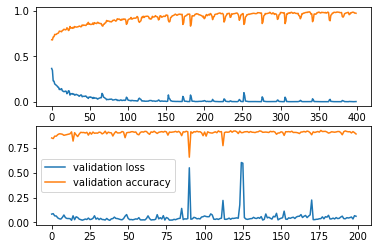

In [40]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

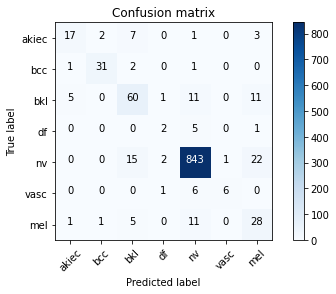

In [42]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [43]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.71      0.57      0.63        30
         bcc       0.91      0.89      0.90        35
         bkl       0.67      0.68      0.68        88
          df       0.33      0.25      0.29         8
          nv       0.96      0.95      0.96       883
        vasc       0.86      0.46      0.60        13
         mel       0.43      0.61      0.50        46

    accuracy                           0.89      1103
   macro avg       0.70      0.63      0.65      1103
weighted avg       0.90      0.89      0.90      1103



Text(0, 0.5, 'Fraction classified incorrectly')

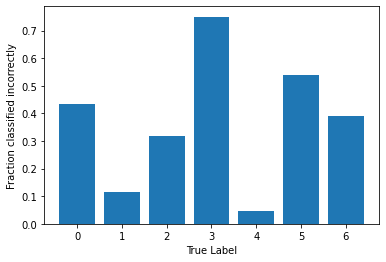

In [44]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## Conclusion

I tried to train with different network structures. When using Densenet-121, the average accuracy of 7 classes on the validation set can reach 92% in 10 epochs. We also calculated the confusion matrix for all classes and the F1-score for each class, which is a more comprehensive indicator that can take into account both the precision and recall of the classification model.Our model can achieve more than 90% on the F1-score indicator.

Due to limited time, we did not spend much time on model training. By increasing in training epochs, adjustmenting of model hyperparameters, and attempting at different networks may further enhance the performance of the model.

## Next plan

How to use image data and patient case data at the same time, my plan is to use CNN to extract features from images, use xgboost to convert medical records into vectors and then concat them with CNN network full-layer features. Two branch networks are trained simultaneously using a loss function. We can refer to the methods used in the advertising CTR estimation task.